Media Sentiment & Topic Evolution: Machine Learning on News Trends

In [ ]:
pip install requests pandas tqdm

In [ ]:
import requests
import pandas as pd
import time
from tqdm import tqdm

# Replace with your actual API key
API_KEY = "85228b14-1898-42df-9062-fe7c474078a1"

# Set API Endpoint
BASE_URL = "https://content.guardianapis.com/search"

# Query Parameters
PARAMS = {
    "api-key": API_KEY,
    "show-tags": "keyword",  # To fetch relevant keywords
    "show-fields": "headline,trailText",  # Additional metadata
    "page-size": 50,  # Number of results per page
    "order-by": "newest",
    "from-date": "2024-01-01",  # Adjust date range as needed
    "to-date": "2024-02-01",
}

# Function to fetch data
def fetch_guardian_data(num_pages=5):
    all_articles = []

    for page in tqdm(range(1, num_pages + 1), desc="Fetching Data"):
        PARAMS["page"] = page
        response = requests.get(BASE_URL, params=PARAMS)
        data = response.json()

        if "response" in data and "results" in data["response"]:
            for article in data["response"]["results"]:
                all_articles.append({
                    "id": article.get("id"),
                    "headline": article["fields"].get("headline", ""),
                    "section": article.get("sectionName", ""),
                    "publication_date": article.get("webPublicationDate", ""),
                    "url": article.get("webUrl", ""),
                    "keywords": ", ".join([tag["webTitle"] for tag in article.get("tags", [])])
                })

        time.sleep(1)  # Sleep to avoid rate limits

    return pd.DataFrame(all_articles)

# Fetch sample dataset
df_sample = fetch_guardian_data(num_pages=2)  # Fetch first 2 pages as a sample
df_sample.to_csv("guardian_sample_data.csv", index=False)

print(df_sample.head())  # Print first few rows
df_sample.to_csv("guardian_sample_data.csv", index=False)
print("Sample dataset saved as 'guardian_sample_data.csv'")


Fetching Data: 100%|██████████| 2/2 [00:04<00:00,  2.41s/it]

                                                  id  \
0  football/2024/feb/01/ten-hag-urges-manchester-...   
1  sport/2024/feb/01/luke-littler-takes-premier-l...   
2  stage/2024/feb/02/groundhog-day-review-tim-min...   
3  technology/2024/feb/01/meta-earnings-q4-zucker...   
4  football/live/2024/feb/01/transfer-deadline-da...   

                                            headline     section  \
0  Ten Hag urges Manchester United to ‘hammer out...    Football   
1  Luke Littler takes Premier League debut in str...       Sport   
2  Groundhog Day review – Tim Minchin’s musical i...       Stage   
3  Meta revenue soars as it pivots to AI and anno...  Technology   
4  Transfer deadline day: Lyon attack West Ham af...    Football   

       publication_date                                                url  \
0  2024-02-01T23:51:56Z  https://www.theguardian.com/football/2024/feb/...   
1  2024-02-01T23:40:49Z  https://www.theguardian.com/sport/2024/feb/01/...   
2  2024-02-01T23:39:

In [ ]:
import requests
import pandas as pd
import time
import random
import os
from datetime import datetime
from textblob import TextBlob  # Sentiment Analysis

# Replace with your actual Guardian API Key
API_KEY = "85228b14-1898-42df-9062-fe7c474078a1"

# API Endpoint
BASE_URL = "https://content.guardianapis.com/search"

# Define sections to fetch data from (Diverse Categories)
SECTIONS = [
    "politics", "business", "science", "sport", "technology", "environment",
    "education", "culture", "health", "world"
]

# Set Maximum API Calls per Day
MAX_API_CALLS = 500  # Guardian API limit

# Fetch Progress File to Resume from Last API Call
PROGRESS_FILE = "guardian_api_progress.txt"
DATA_FILE = "guardian_large_dataset.csv"

# Check how many API calls have been made today
def get_api_calls_today():
    if os.path.exists(PROGRESS_FILE):
        with open(PROGRESS_FILE, "r") as f:
            return int(f.read().strip())
    return 0

# Update API call count
def update_api_calls_count(count):
    with open(PROGRESS_FILE, "w") as f:
        f.write(str(count))

# Load existing data to prevent duplicates
if os.path.exists(DATA_FILE):
    df_existing = pd.read_csv(DATA_FILE)
    collected_ids = set(df_existing["id"])
    print(f"Resuming collection. Already collected {len(collected_ids)} articles.")
else:
    df_existing = pd.DataFrame()
    collected_ids = set()

# Function to fetch data
def fetch_guardian_data():
    all_articles = []
    api_calls_made = get_api_calls_today()

    for section in SECTIONS:
        for page in range(1, 11):  # Fetch 10 pages per section per day
            if api_calls_made >= MAX_API_CALLS:
                print("Reached today's API limit. Stopping collection.")
                update_api_calls_count(api_calls_made)
                return pd.DataFrame(all_articles)

            params = {
                "api-key": API_KEY,
                "show-tags": "keyword",
                "show-fields": "headline,trailText,bodyText,byline",
                "section": section,
                "page-size": 50,
                "order-by": "newest",
                "page": page
            }

            response = requests.get(BASE_URL, params=params)
            data = response.json()

            if "response" in data and "results" in data["response"]:
                for article in data["response"]["results"]:
                    if article["id"] not in collected_ids:  # Avoid duplicates
                        headline = article["fields"].get("headline", "")
                        body_text = article["fields"].get("bodyText", "")
                        sentiment = TextBlob(headline).sentiment.polarity  # Sentiment Analysis (-1 to 1)

                        all_articles.append({
                            "id": article.get("id"),
                            "headline": headline,
                            "section": article.get("sectionName", ""),
                            "publication_date": article.get("webPublicationDate", ""),
                            "url": article.get("webUrl", ""),
                            "author": article["fields"].get("byline", ""),
                            "keywords": ", ".join([tag["webTitle"] for tag in article.get("tags", [])]),
                            "body_text": body_text,
                            "sentiment": sentiment
                        })
                        collected_ids.add(article["id"])

            api_calls_made += 1
            update_api_calls_count(api_calls_made)

            # Sleep to avoid rate limits
            time.sleep(random.uniform(1, 2))

            # Save intermediate results
            if len(all_articles) > 0:
                df_new = pd.DataFrame(all_articles)
                df_combined = pd.concat([df_existing, df_new], ignore_index=True)
                df_combined.to_csv(DATA_FILE, index=False)
                print(f"Saved {len(df_combined)} total articles.")

    return pd.DataFrame(all_articles)

# Run data collection
df_large = fetch_guardian_data()


Saved 50 total articles.
Saved 100 total articles.
Saved 150 total articles.
Saved 200 total articles.
Saved 250 total articles.
Saved 300 total articles.
Saved 350 total articles.
Saved 400 total articles.
Saved 450 total articles.
Saved 500 total articles.
Saved 550 total articles.
Saved 600 total articles.
Saved 650 total articles.
Saved 700 total articles.
Saved 750 total articles.
Saved 800 total articles.
Saved 850 total articles.
Saved 900 total articles.
Saved 950 total articles.
Saved 1000 total articles.
Saved 1050 total articles.
Saved 1100 total articles.
Saved 1150 total articles.
Saved 1200 total articles.
Saved 1250 total articles.
Saved 1300 total articles.
Saved 1350 total articles.
Saved 1400 total articles.
Saved 1450 total articles.
Saved 1500 total articles.
Saved 1550 total articles.
Saved 1600 total articles.
Saved 1650 total articles.
Saved 1700 total articles.
Saved 1750 total articles.
Saved 1800 total articles.
Saved 1850 total articles.
Saved 1900 total arti

In [ ]:
import pandas as pd
import re
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

# Load the dataset
file_path = "guardian_large_dataset.csv"  # Ensure correct file path
df = pd.read_csv(file_path)

# Drop duplicate articles based on headline
df.drop_duplicates(subset=["headline"], inplace=True)

# Drop rows with missing essential values (body_text, headline, section)
df.dropna(subset=["body_text", "headline", "section"], inplace=True)

# Convert all text to lowercase
df["headline"] = df["headline"].str.lower()
df["body_text"] = df["body_text"].str.lower()

# Remove special characters, numbers, and extra spaces
df["body_text"] = df["body_text"].apply(lambda x: re.sub(r"[^a-z\s]", "", x))

# Remove stopwords
df["body_text"] = df["body_text"].apply(lambda x: " ".join([word for word in x.split() if word not in ENGLISH_STOP_WORDS]))

# Convert sentiment column to numeric (handle any non-numeric values)
df["sentiment"] = pd.to_numeric(df["sentiment"], errors="coerce")

# Save cleaned dataset
cleaned_file_path = "guardian_cleaned_dataset.csv"
df.to_csv(cleaned_file_path, index=False)

print(f"✅ Cleaned dataset saved as '{cleaned_file_path}' with {len(df)} articles.")


✅ Cleaned dataset saved as 'guardian_cleaned_dataset.csv' with 4425 articles.


1. Articles Per Section

Shows how many articles belong to each section (Politics, Tech, Sports, etc.).

<ipython-input-24-032de65777ed>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=df["section"].value_counts().index, x=df["section"].value_counts().values, palette="viridis")


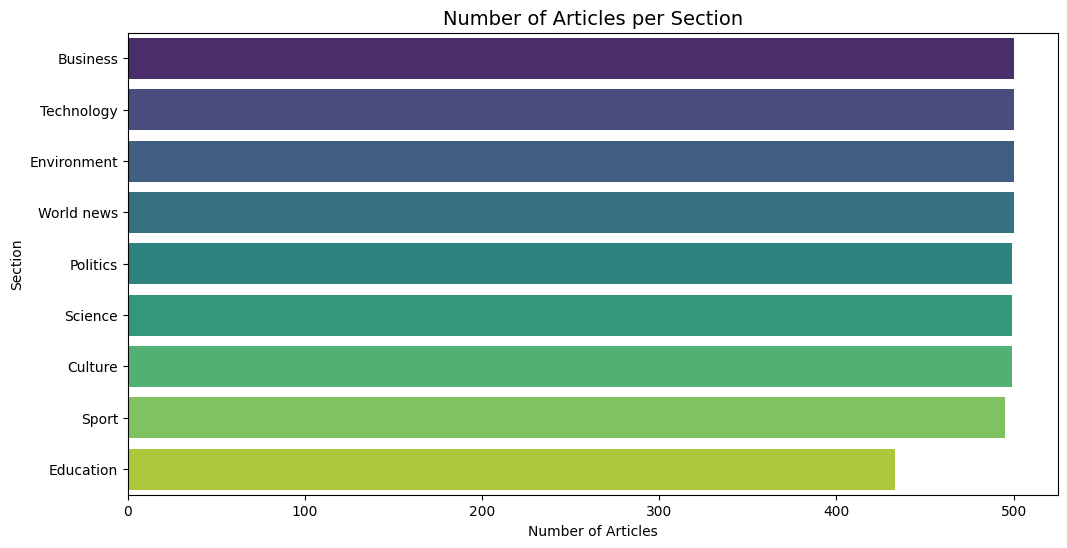

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Load cleaned dataset
df = pd.read_csv("guardian_cleaned_dataset.csv")

plt.figure(figsize=(12, 6))
sns.barplot(y=df["section"].value_counts().index, x=df["section"].value_counts().values, palette="viridis")
plt.title("Number of Articles per Section", fontsize=14)
plt.xlabel("Number of Articles")
plt.ylabel("Section")
plt.show()


2. Articles Published Over Time

Tracks how publication trends have changed over time.

<ipython-input-25-5b8b30bf5afd>:5: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df["year_month"] = df["publication_date"].dt.to_period("M")


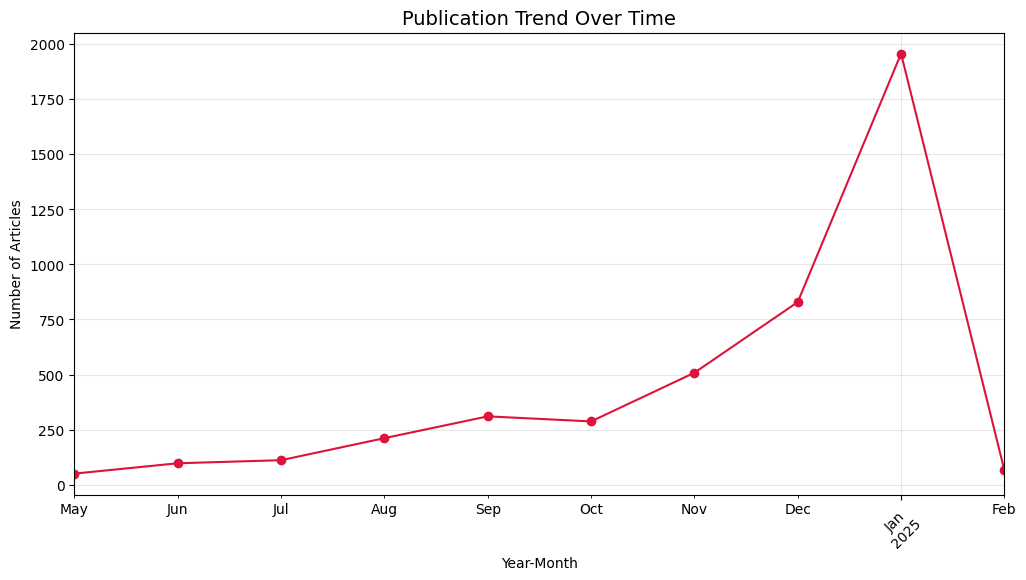

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

df["publication_date"] = pd.to_datetime(df["publication_date"])
df["year_month"] = df["publication_date"].dt.to_period("M")

df["year_month"].value_counts().sort_index().plot(kind="line", figsize=(12, 6), marker="o", color="crimson")
plt.title("Publication Trend Over Time", fontsize=14)
plt.xlabel("Year-Month")
plt.ylabel("Number of Articles")
plt.grid(alpha=0.3)
plt.xticks(rotation=45)
plt.show()


3. Word Cloud of Headlines

Creates a beautiful word cloud showing the most common words in news headlines.

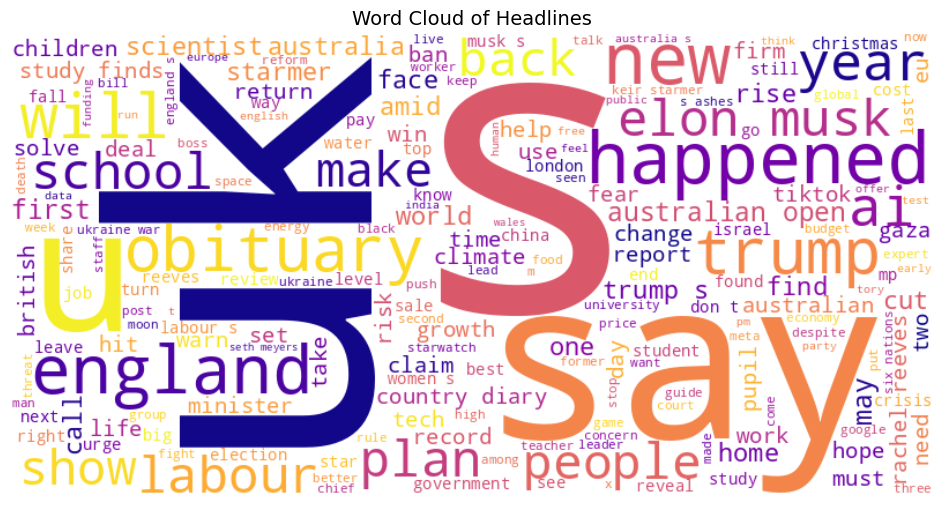

In [ ]:
from wordcloud import WordCloud

wordcloud = WordCloud(width=800, height=400, background_color="white", colormap="plasma").generate(" ".join(df["headline"]))
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud of Headlines", fontsize=14)
plt.show()


4. Sentiment Score Distribution

Shows if news is mostly positive, negative, or neutral.

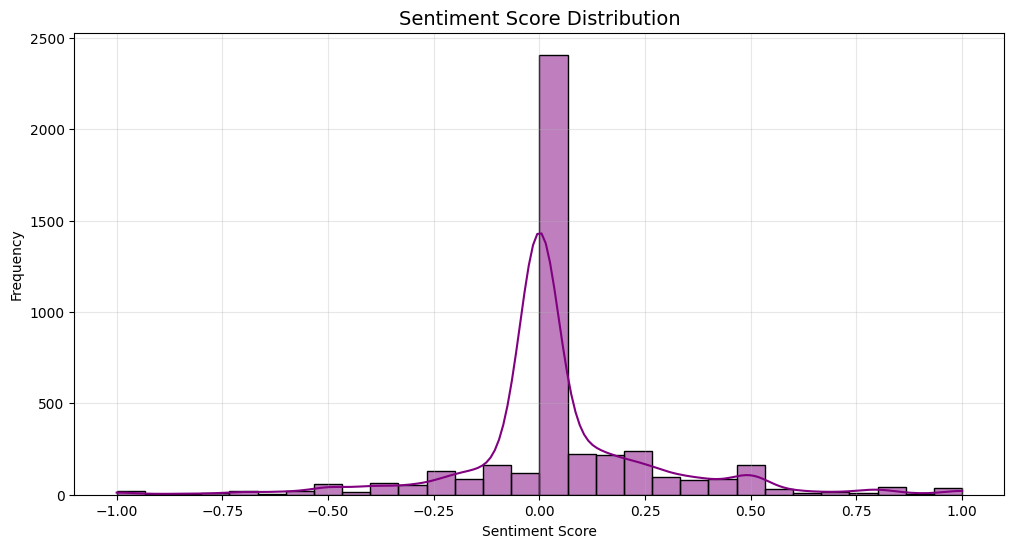

In [ ]:
import seaborn as sns

plt.figure(figsize=(12, 6))
sns.histplot(df["sentiment"], bins=30, kde=True, color="purple")
plt.title("Sentiment Score Distribution", fontsize=14)
plt.xlabel("Sentiment Score")
plt.ylabel("Frequency")
plt.grid(alpha=0.3)
plt.show()


5. Most Frequent Keywords

Finds the top 10 most used keywords in news articles.

<ipython-input-28-f37292a96b39>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(counts), y=list(keywords), palette="coolwarm")


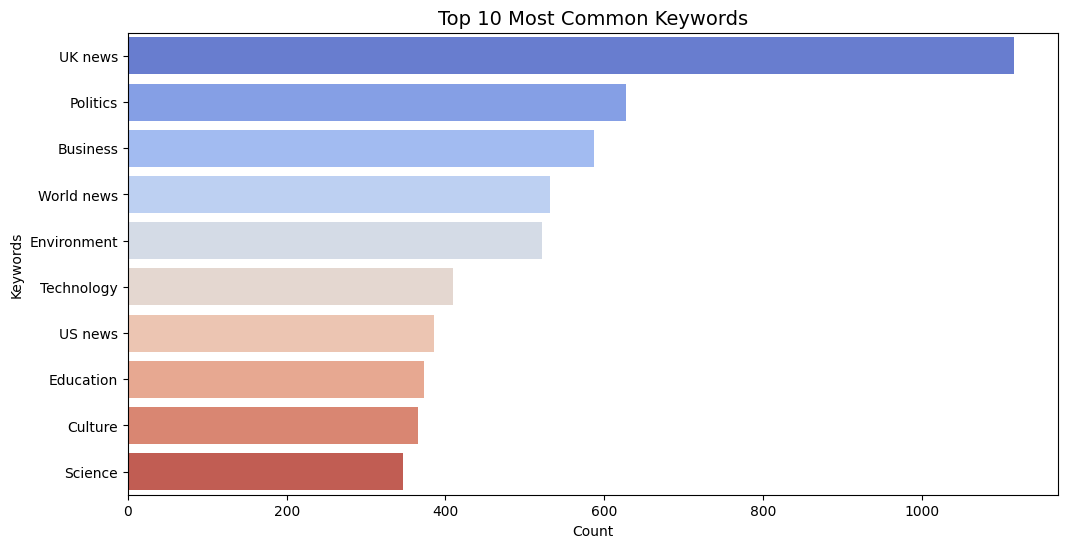

In [ ]:
from collections import Counter
import seaborn as sns

keyword_counts = Counter(",".join(df["keywords"].dropna()).split(", "))
common_keywords = keyword_counts.most_common(10)
keywords, counts = zip(*common_keywords)

plt.figure(figsize=(12, 6))
sns.barplot(x=list(counts), y=list(keywords), palette="coolwarm")
plt.title("Top 10 Most Common Keywords", fontsize=14)
plt.xlabel("Count")
plt.ylabel("Keywords")
plt.show()


6. Average Sentiment per Section

Shows whether different news categories are more positive or negative.

<ipython-input-29-0ff46a3e9395>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df, x="section", y="sentiment", palette="Spectral", estimator=lambda x: x.mean())


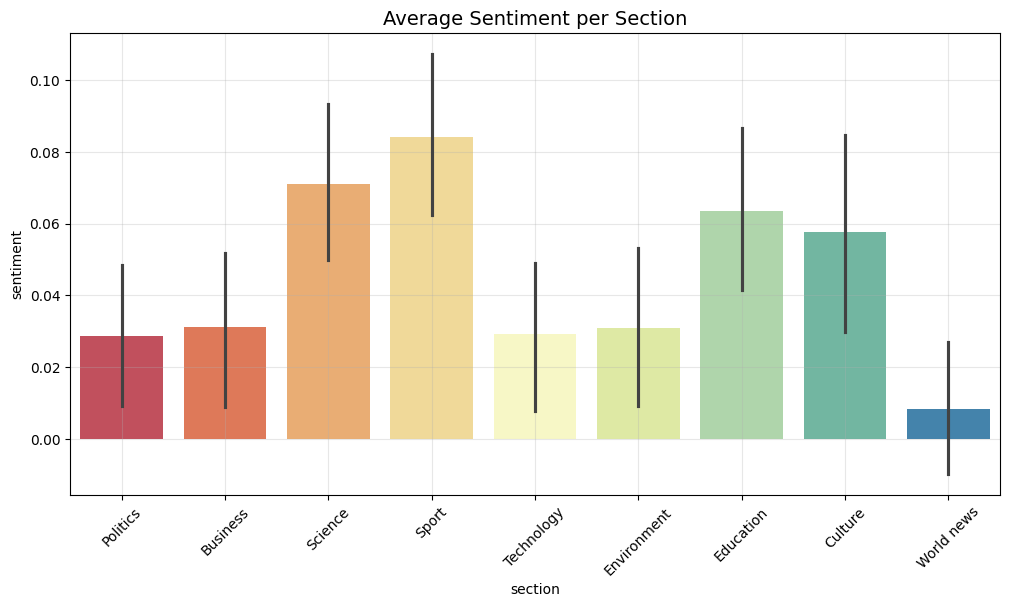

In [ ]:
plt.figure(figsize=(12, 6))
sns.barplot(data=df, x="section", y="sentiment", palette="Spectral", estimator=lambda x: x.mean())
plt.title("Average Sentiment per Section", fontsize=14)
plt.xticks(rotation=45)
plt.grid(alpha=0.3)
plt.show()


7. Top 10 Authors with Most Articles

Finds the most published authors in the dataset.

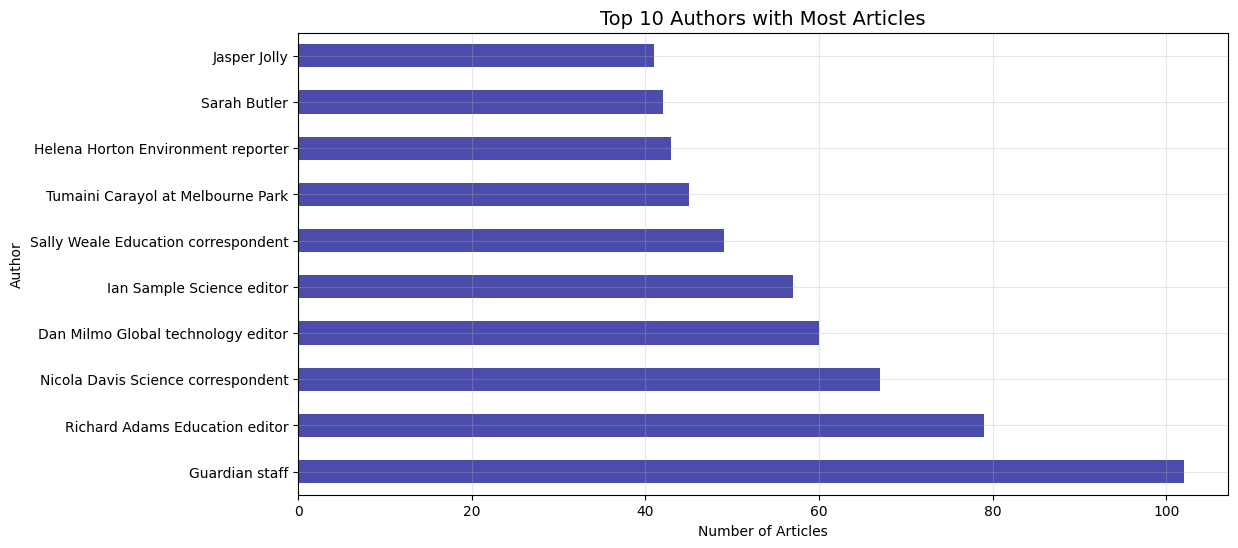

In [ ]:
top_authors = df["author"].value_counts().nlargest(10)
plt.figure(figsize=(12, 6))
top_authors.plot(kind="barh", color="darkblue", alpha=0.7)
plt.title("Top 10 Authors with Most Articles", fontsize=14)
plt.xlabel("Number of Articles")
plt.ylabel("Author")
plt.grid(alpha=0.3)
plt.show()


8. Article Length Distribution

Shows the length of articles to see if some are much longer than others.

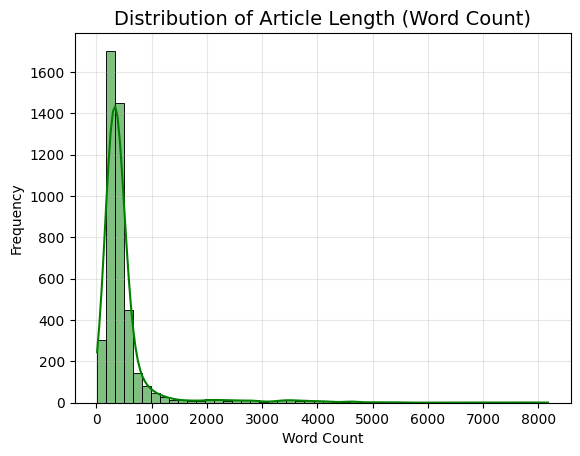

In [ ]:
df["word_count"] = df["body_text"].apply(lambda x: len(str(x).split()))

sns.histplot(df["word_count"], bins=50, kde=True, color="green")
plt.title("Distribution of Article Length (Word Count)", fontsize=14)
plt.xlabel("Word Count")
plt.ylabel("Frequency")
plt.grid(alpha=0.3)
plt.show()


9. Relationship Between Article Length & Sentiment

Finds if longer articles are more positive or negative.

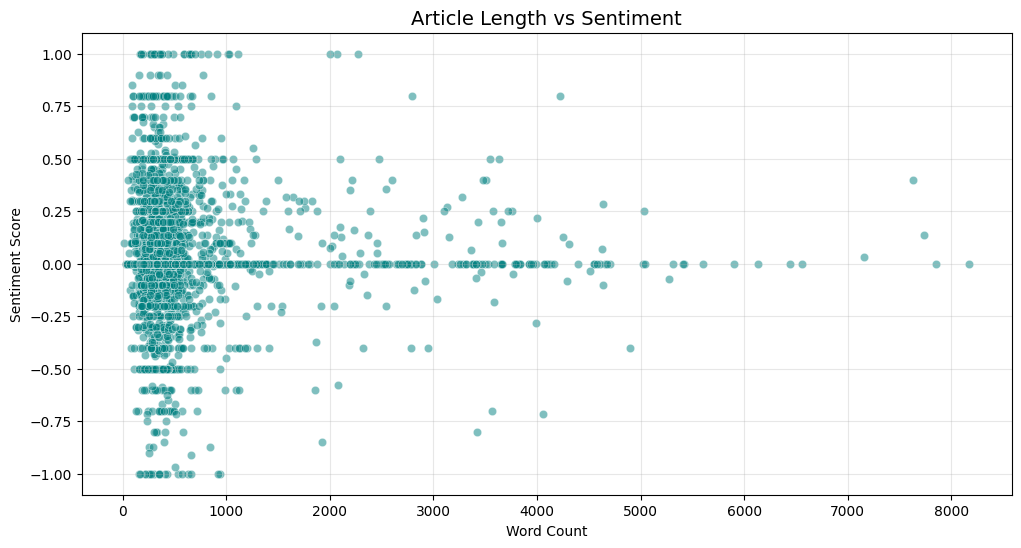

In [ ]:
plt.figure(figsize=(12, 6))
sns.scatterplot(data=df, x="word_count", y="sentiment", alpha=0.5, color="teal")
plt.title("Article Length vs Sentiment", fontsize=14)
plt.xlabel("Word Count")
plt.ylabel("Sentiment Score")
plt.grid(alpha=0.3)
plt.show()


10. Word Cloud of Full Articles

Creates a beautiful word cloud showing the most used words in articles.


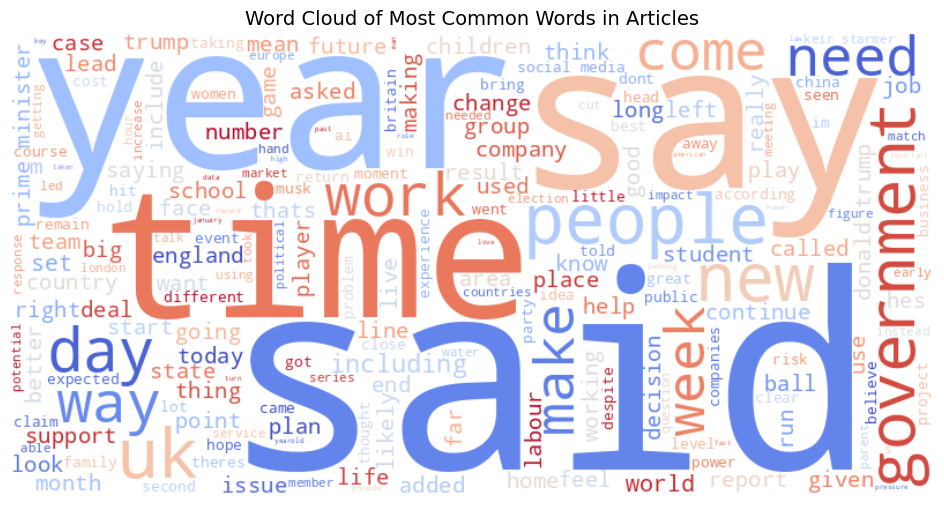

In [ ]:
wordcloud_articles = WordCloud(width=800, height=400, background_color="white", colormap="coolwarm").generate(" ".join(df["body_text"]))
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud_articles, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud of Most Common Words in Articles", fontsize=14)
plt.show()

11. Heatmap of Correlations Between Numeric Variables

This visualization shows how different numerical features (e.g., sentiment, word count) relate to each other.

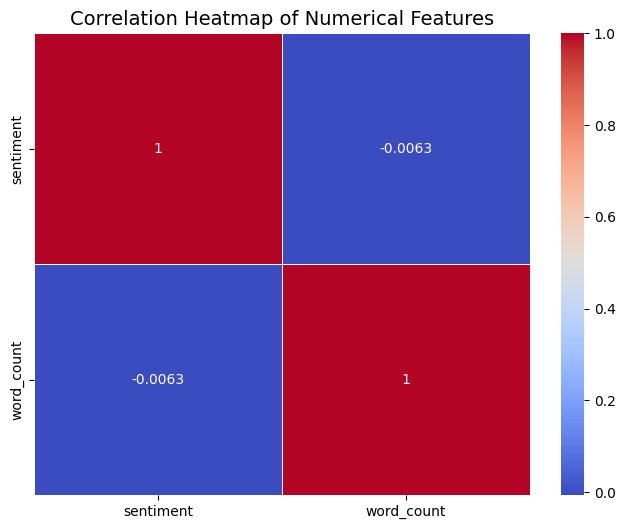

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
sns.heatmap(df[["sentiment", "word_count"]].corr(), annot=True, cmap="coolwarm", linewidths=0.5)
plt.title("Correlation Heatmap of Numerical Features", fontsize=14)
plt.show()


12. Pie Chart of Article Distribution Across Sections

This helps visualize the percentage of articles in each section.

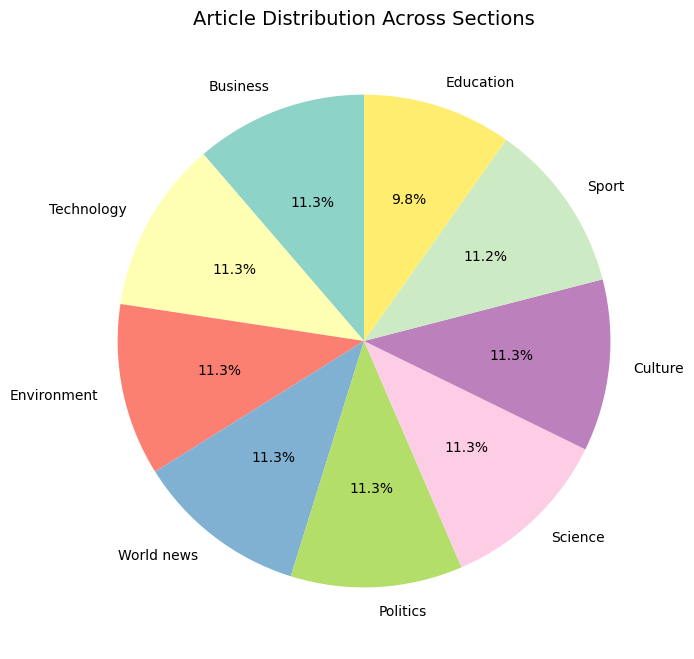

In [ ]:
plt.figure(figsize=(8, 8))
df["section"].value_counts().plot.pie(autopct="%1.1f%%", cmap="Set3", startangle=90)
plt.title("Article Distribution Across Sections", fontsize=14)
plt.ylabel("")  # Remove default label
plt.show()


13. Box Plot of Sentiment Score Per Section

Shows the spread of sentiment scores for each news category, highlighting outliers and variability.

<ipython-input-36-118c7f5c9e15>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x="section", y="sentiment", palette="Paired")


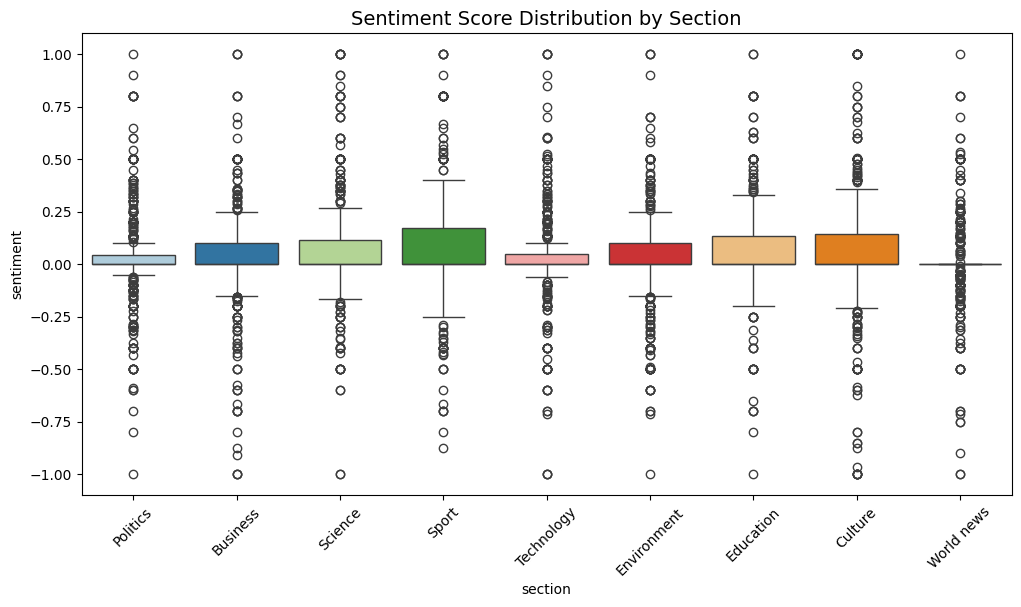

In [ ]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x="section", y="sentiment", palette="Paired")
plt.xticks(rotation=45)
plt.title("Sentiment Score Distribution by Section", fontsize=14)
plt.show()


14. Hourly Distribution of Published Articles

This shows when articles are most commonly published during the day.

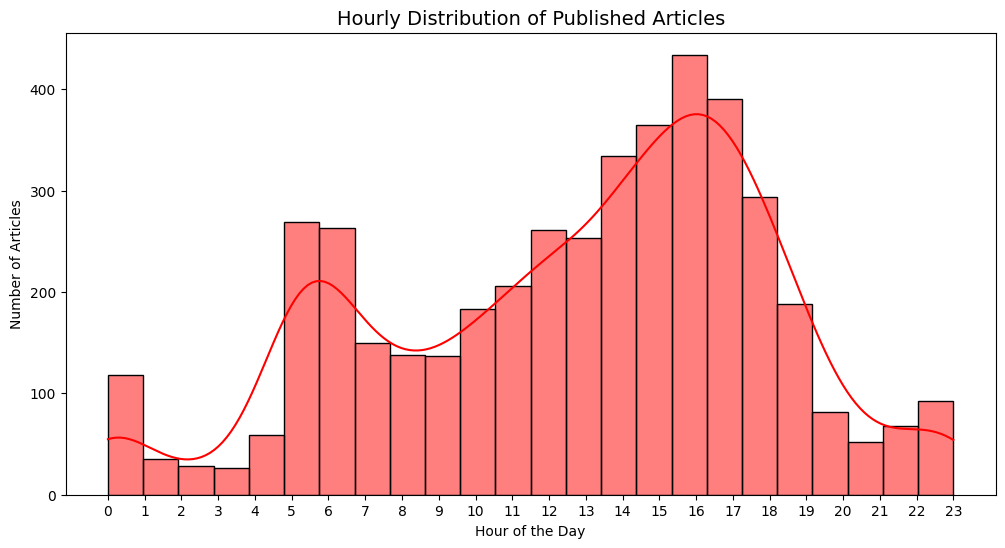

In [ ]:
df["hour"] = pd.to_datetime(df["publication_date"]).dt.hour

plt.figure(figsize=(12, 6))
sns.histplot(df["hour"], bins=24, kde=True, color="red")
plt.xticks(range(0, 24))
plt.title("Hourly Distribution of Published Articles", fontsize=14)
plt.xlabel("Hour of the Day")
plt.ylabel("Number of Articles")
plt.show()


15. Keyword Co-Occurrence Network Graph

Finds how different keywords often appear together, showing hidden relationships between topics.

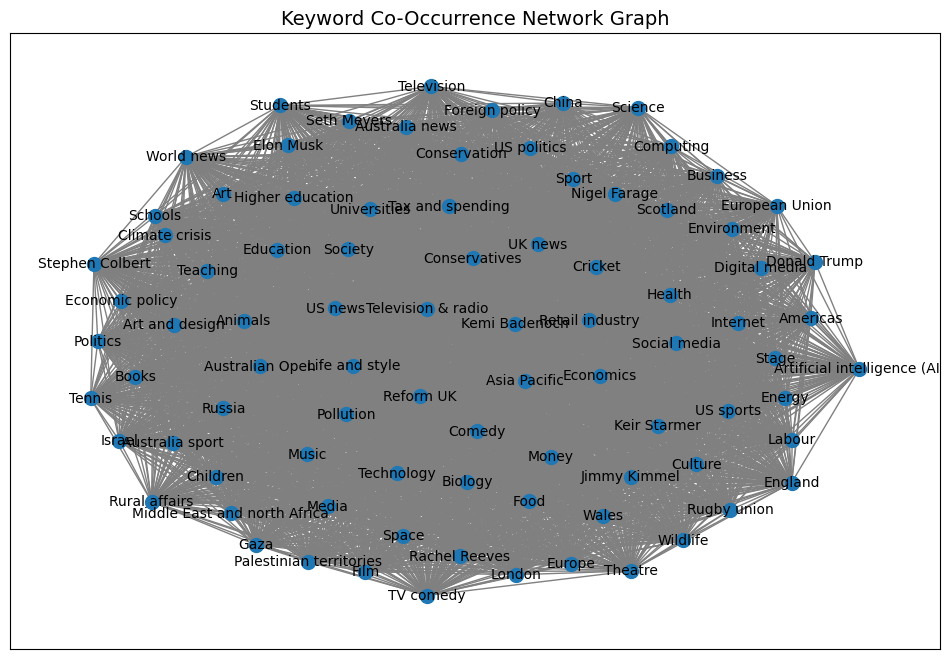

In [ ]:
import networkx as nx

# Extract most common keyword pairs
keyword_counts = Counter(",".join(df["keywords"].dropna()).split(", "))
common_keywords = [kw for kw, count in keyword_counts.items() if count > 50]

# Create a network graph
G = nx.Graph()
for kw in common_keywords:
    for other_kw in common_keywords:
        if kw != other_kw and (kw, other_kw) not in G.edges:
            G.add_edge(kw, other_kw)

plt.figure(figsize=(12, 8))
nx.draw_networkx(G, with_labels=True, node_size=100, font_size=10, edge_color="gray")
plt.title("Keyword Co-Occurrence Network Graph", fontsize=14)
plt.show()
